# Задача: Распознавание разнообразных блюд в ресторане

Хоть и это и должен быть финальный отчет, но хотелось бы совместить свои мысли и рассуждения вместе с отчетом о работе

## 1. Анализ тестового задания 

Прежде чем приступить к работе, я решил, для начала, вчитаться в тестовое задание, задав себе несколько вопросов:
1. Какая стоит бизнес задача?
2. Насколько сложен проект для реализации с условием, что у нас есть несколько видеозаписей.
3. Какие объекты и как разметить?
4. И что я мог бы предложить этому проекту, кроме как детекции объектов?

Распознавание разнообразных блюд в ресторане в принципе позволяет ресторанам и местам общепита следить за подаваемыми блюдами, оценить количество. Просмотрев видеозаписи, которые были предоставлены для тестового задания, я понял, что тарелки, чашки и т.д довольно статичны, и сложность детекции таких объетов на том датасете, что получится из видео, не так сложна. В процессе анализа я задумался, а что можно еще предоставить клиенту, кроме как нахождения блюд? 

В параллеле с этим шло и задача того, а что именно мы будем детектить. Люди доедают и оставляют пустые тарелки. Почему бы не детектить и это. Что это дает в будущем?

Оценить, а доедают ли порцию того или иного блюда клиенты?

Можно отслеживать определенное блюда, оценить, доедают ли ее. Собрать в будущем статистику для всех блюд и провести анализ. Например, в случае, если более 80% клиентов не доедают суп Харчо, можно сделать следующее:
1. убрать блюдо из меню и заменить его более лучшим вариантом
2. возможно стоит уменьшить размер порции и вместе с ним уменьшить и цену на него. Учитывая экономические ситуации в странах, это может привлечь больше покупателей и снизить издержки(меньше уходит в отходы, а раз порция меньше, то и затраты на порцию меньше)
3. уменьшить порцию оставив цену такой же. Это может сохранить цену на более длительное время с учетом инфляции.

Можно найти много статей, где используются те или пункты, что я описал и часть из них неплохо увеличивало продажи и снижали издержки.

Ну и вопрос технического характера, как разметить? Я не силен в блюдах, поэтому тут можно отдать фотографию ИИ и спросить какие блюда тут имеются. А так как объеты тут в основном статические, используем CVAT, который позволяет переносить ббоксы на все фреймы. 

Еще пришла мысль, что раз объеты статичны, нам нет необходимости из видео вырывать каждый кадр, получать датасет размера 2к+ и все это время размечать. Достаточно взять кадр в секунду и получить 300 данных

##### Итог. 

1. Берем из видео 1 кадр в секунду и сохраняем
2. Отдаем 2-3 фрейма ИИ и получаем описание и названия блюд.
3. Делаем список всех объектов, как блюда, так и пустые стаканы и тарелки
4. Размечаем это в CVAT и смотрим на статистику объектов 

Затраченное время - 5 часа

## 2. Создание датасета

После ИИ мы получили следующие классы

1. salad_with_halloumi
2. quesadilla
3. borsch
4. greek_salad
5. lamb_ribs
6. tea_infuser
7. empty_cups
8. empty_plate
9. tea_cup
10. pumpkin_cream_soup


После получения фреймов из видеозаписей, мы получили 320 изображении

Локально поднимаем CVAT, загружем датасет и размечаем. Можно было дать ИИ все разметить, но это затратно. Так как изображении немного, а объекты статичны, можно и самому быстро разметить. Получили 320 txt файлов разметки в формате yolo

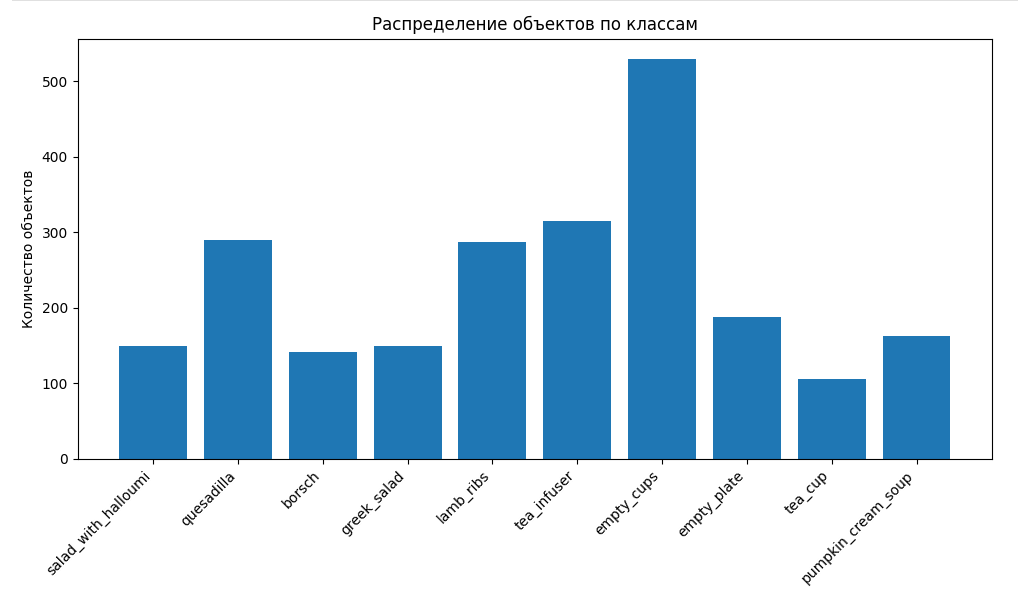

Далее создаем структуру датасета для обучения yolo. Чтобы обучить модель, мы воспользуем популярной библиотекой ultralytircs

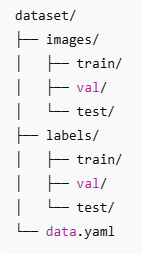

Разбиваем датасет на трейн, тест и валидацию в соотношении 70 на 15 на 15 и посмотрим на распределение объектов

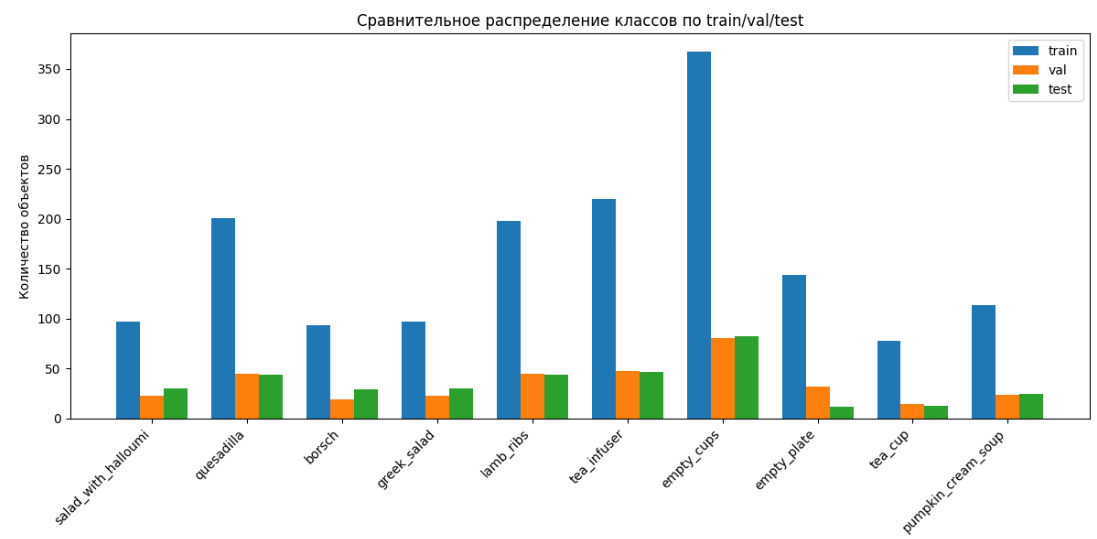

##### Итог: 
Как видим, все объекты есть и в трейне, и в тесте, и в валидации, чтобы более точно оценить работу детектора

Затраченное время: 3 часа

## 3. Обучение модели

Выбор модели. Учитывая из вакансии, чем занимается компания, основные решения приходят на edge-устройства. Какую именно модель выбрать стоит опираться на то, где оно будет работать. Раз используются устройства, такие как, jenson nano, xavier и тд, стоит подумать о легкой модели. Но подумав, почему бы нам не взять самую тяжелую и лучшую модель и конвертировать в tensorrt. Такое решение хватит на 8ГБ cuda памяти.

В этой задаче не нужен реалтайм. Важно качество детекции. Вполно можно брать раз в секунду кадр и находить объекты так. Это в случае, если все таки edge устройства будут использоваться. Если работает все на сервере, можно все ту же тяжелую модель(в пределах разумного, если более легкая модель не отстает по точности)

Тут можно конечно задуматься и о том, а где обучать тяжелую модель, 8ГБ не хватит, если есть сервер для обучения. Но можно арендовать и потратить 5 баксов и обучить детектор.

На первой итерации мы берем модель yolov11x, добавляем в обучении аугментации:
1. Горизонтальный поворот
2. Вертикальный поворот
3. Сдвиг
4. Немного шума

Берем изображение размера 640 на 640

В результате на тестовых данных мы получаем

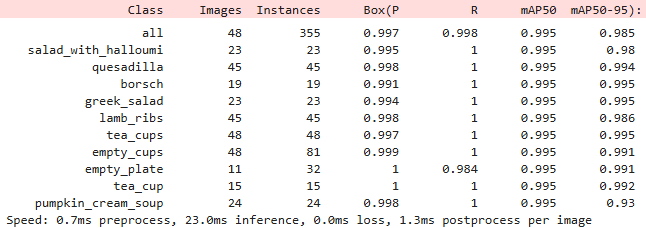

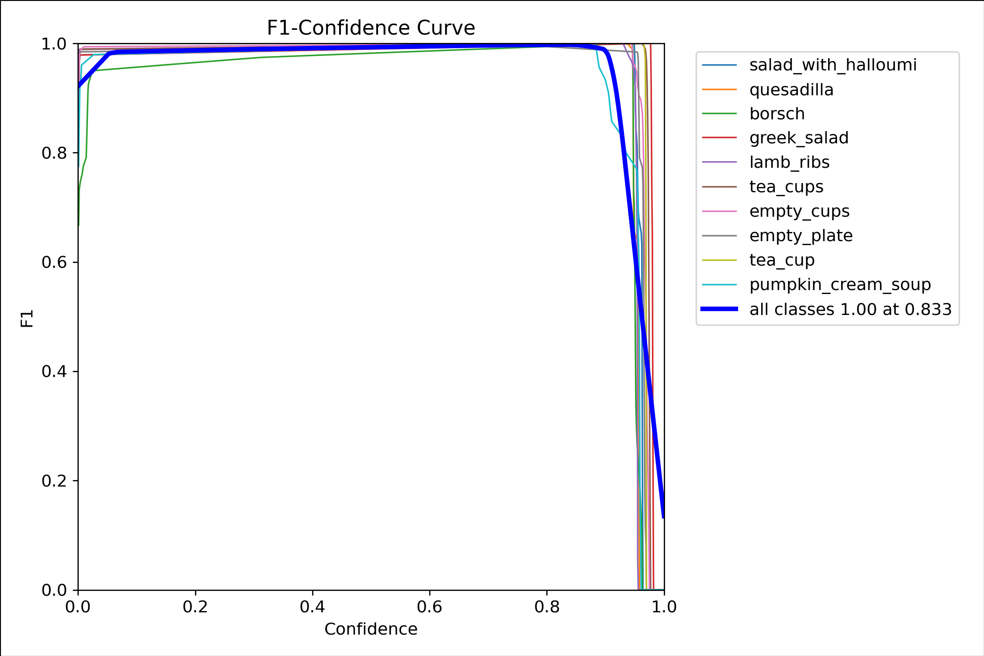

##### Вывод: 
Уже на первой итерации мы добились почти самых высоких результатов. С учетом нынешнего датасета, даже если мы возьмем модель полегче, мы получим близкие этому результаты

Затраченное время: 2 часа

### 4. Сложности, подходы и выводы.

Для данного тестового задания нет особых сложностей в определении 10-ти классов. Тут достаточно использовать этот подход и он будет хорошо работать

НО! В реальной задаче я бы не рекомендовал этот метод. Этот метод рабочий и может показать себя хорошо, но всплывают много проблем и сложностей:

Масштабируемость. В случае, когда ассортимент в ресторане увеличился и необходимо детектить новые блюда, придется опять собирать датасет, обучать детектор и еще сново заливать его в edge устройства, даже если это устройство подключено к интернету, очень проблематично. А таких заведении может быть много, для каждого обучать свой детектор. Поэтому это решение может подойдет только для одного крупного ресторана, где ассортимент не меняется долгое время. Но, к сожалению, в условиях бизнеса это может быть не рентабельно и никому не нужно

Интереснее подход, когда мы находим 3 класса:
1. блюдо
2. Пустые тарелки
3. пустые стаканы

Мы одним классом определяем все блюда, далее у нас будет обучен отдельный классификатор блюд. Решение чуть медленнее предыдущего, но намного проще. Детектор будет стабильнее работать, так как даже если появится новое блюдо, нам достаточно переобучить классификатор. Также это решение по точности сравнится с соло детектором. В этом случае на все рестораны может быть один детектор, и разные классификаторы. Масштабируемость тут получше.

Более интересный подход. 

Детектор также на 3 класса, но мы переводим блюда в векторное представление и с помощью векторного поиска определяем, что это за блюдо. Масштабируемость тут максимально простое, появилось новое блюдо, добавили в БД и теперь мы можем его идентифицировать. Не надо менять модели и делать еще какие то сложные махинации, в общем БД для всех ресторанов или БД для одного ресторана мы можем спокойно удалять или добавлять позиции и определять блюдо. 

Подход звучит круто, но на деле, векторный поиск работает(по моему опыту) слабее, чем классификация. Необходимо найти хорошую модель для получения эмбеддингов(можно кстати обучить классификатор из второго подхода и убрать классификационную голову и использовать его), но обычно берут трансформер. Еще необходимо настраивать множества параметров(порог меры близости, саму меру близости и еще как в бд хранить и какую взять)

вдобавок это решение будет в разы медленнее чем предыдущие две

У каждого подхода есть свои плюсы и минусы, решение зависит от желания заказчика, поэтому говорить, что первый подход не нужен и почему я не показал другой подход, раз есть и лучше не следует. Есть запросы, где хватит и первого подхода, поэтому я им и воспользовался(тестовое задание построено так, что первый подход здесь идеален, а остальные слишком избыточны)

### 5. Немного о себе

С Yolo я знаком давно, еще с версии v2. Использовал я детектор и в определении средств индивидуальной защиты, и в детекции автомобильных номеров и нахождении логотипов и т.д.

Все три подхода, которые я описал, я использовал в прошлых работах:
1. определение СИЗ я использовал второй подход, так как были различные типы касок и людей без касок, были сложности со сбором датасета для детекции.
2. Автомобильные номера, типы транспортных средств и тд использовал первый подход
3. определение логотипов использовал третий подход, потому что логотипов слишком много, чтобы их классифицировать

Если вам интересен мой опыт работы, зовите на собеседование))

##### Общее затраченное время: 20 часов